In [1]:
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt
import codebase

In [2]:
res_shp = codebase.load_data.load_GRanD()

ERROR 1: PROJ: proj_create_from_database: Open of /global/home/users/ann_scheliga/.conda/envs/rioxarray_env/share/proj failed


In [3]:
# Create subset from dam name or from lat/lon values
dam_name = 'Indirasagar'
bbox_array = [76.420001, 21.9051, 76.90001, 22.47001]


subset_gpd = codebase.area_subsets.check_for_multiple_dams(dam_name,res_shp)
subset_bbox = subset_gpd.geometry.buffer(0).bounds

# subset_bbox = pd.DataFrame(
#         data=np.array(bbox_array).reshape(1, -1),
#         columns=["minx", "miny", "maxx", "maxy"],
#     )

In [4]:
dem_DA = codebase.load_data.load_DEM_subset_as_rxrDA(subset_bbox)
fw_DA = codebase.load_data.load_CYGNSS_001_all_months(subset_bbox)

In [5]:
np.testing.assert_allclose(dem_DA['lat'].values, fw_DA['lat'].values)
dem_DA['lat'] = fw_DA['lat']
np.testing.assert_allclose(dem_DA['lon'].values, fw_DA['lon'].values)
dem_DA['lon'] = fw_DA['lon']

In [6]:
fw_DA_binary = codebase.area_calcs.cygnss_convert_to_binary(fw_DA)
fw_DA_binary['time'] = codebase.time_series_calcs.CYGNSS_timestep_to_pdTimestamp(fw_DA['time'])

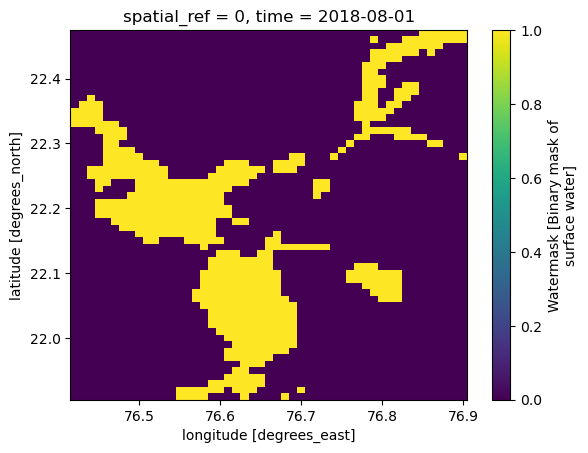

In [7]:
fw_DA_binary[0,:,:].plot()

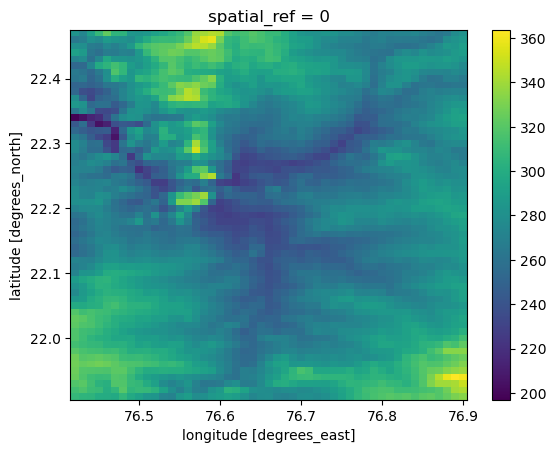

In [8]:
dem_DA.plot()

In [9]:
dem_subset = dem_DA.where(fw_DA_binary==1)
# dem_subset.to_netcdf('../indirasagar_dem_subset.nc')

In [10]:
dem_subset

<xarray.DataArray (lat: 57, lon: 49, time: 57)>
array([[[         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        ...,
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan]],

       [[         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
...
        [278.14103245, 278.14103245, 278.14103245, ...,          nan,
                  nan,          nan],
        [282.41749805, 282.41749805, 282.41749805, ...,          nan,
                  nan,          nan],
        [285.63688476, 285.63688476, 285.63688476, ...,          nan,
                  nan,          nan]],

       [[         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        ...,
        [265.25868782, 265.25868782, 265.25868782, ..., 265.25868782,
         265.25868782,          nan],
        [276.78488506, 276.78488506, 276.78488506, ..., 276.78488506,
                  nan,          nan],
        [281.11772408, 281.11772408, 281.11772408, ...,          nan,
                  nan,          nan]]])
Coordinates:
    spatial_ref  int64 0
  * lat          (lat) float32 21.91 21.92 21.93 21.94 ... 22.45 22.46 22.47
  * lon          (lon) float32 76.42 76.43 76.44 76.45 ... 76.88 76.89 76.9
  * time         (time) datetime64[ns] 2018-08-01 2018-09-01 ... 2023-04-01

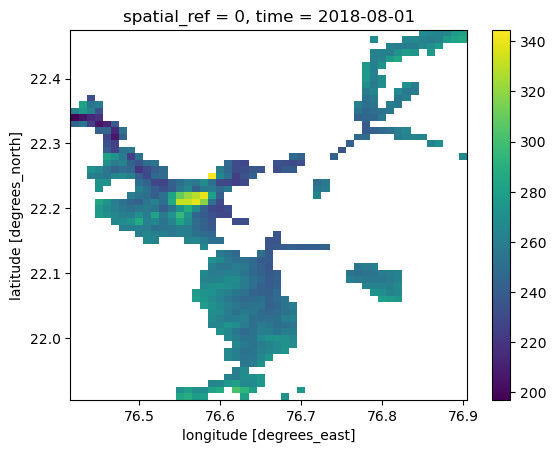

In [11]:
dem_subset[:,:,0].plot()

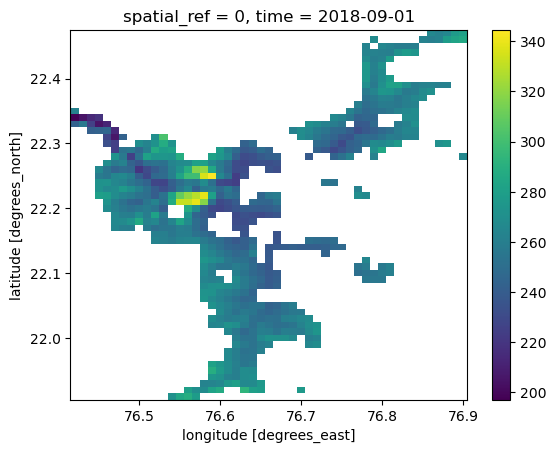

In [12]:
dem_subset[:,:,1].plot()

## Grab DEM values in CYGNSS change
1. Get difference in CYGNSS maps between consecutive months
2. Get DEM values at CYGNSS change area
3. Take mode of DEM values

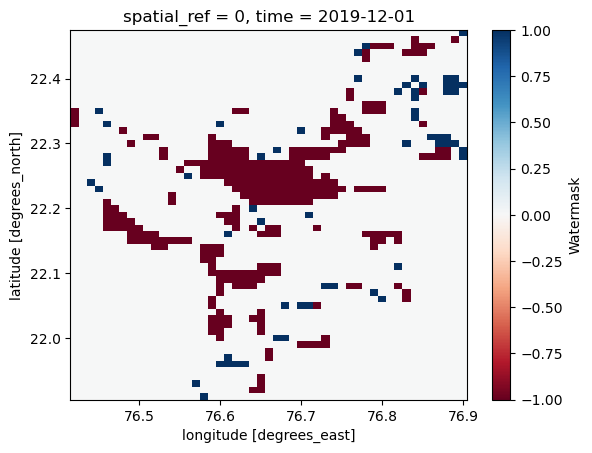

In [13]:
# 1. Get the difference between two months of CYGNSS extent
fw_DA_binary_diff = fw_DA_binary.diff('time')
    #  1 = increase in extent
    #  0 = no change in extent
    # -1 = decrease in extent
fw_DA_binary_diff.isel(time=15).plot(cmap='RdBu')

In [14]:
# 2. Get DEM values at CYGNSS change area
dem_expand = dem_DA.where(fw_DA_binary_diff==1)
dem_decline = dem_DA.where(fw_DA_binary_diff==-1)

bin_edges = np.array([196.97297714, 200.66256603, 204.35215492, 208.04174381,
       211.7313327 , 215.42092159, 219.11051048, 222.80009937,
       226.48968826, 230.17927715, 233.86886604, 237.55845493,
       241.24804382, 244.93763271, 248.6272216 , 252.31681049,
       256.00639938, 259.69598827, 263.38557716, 267.07516605,
       270.76475494, 274.45434383, 278.14393272, 281.83352161,
       285.5231105 , 289.21269939, 292.90228828, 296.59187717,
       300.28146606, 303.97105495, 307.66064384, 311.35023273,
       315.03982162, 318.72941051, 322.4189994 , 326.10858829,
       329.79817718, 333.48776607, 337.17735496, 340.86694385,
       344.55653274])
hist_kwargs = {'bins': bin_edges,'density':False,'facecolor':'darkgrey','alpha':0.7}

In [15]:
def decide_expansion_or_shrinkage(input_DA):
    expand_count = (input_DA== 1).sum()
    shrink_count = (input_DA==-1).sum()
    if   expand_count*2 <= contract_count:
        return -1
    elif shrink_count*2 <= expand_count:
        return 1
    else:
        return 0
    
# expand_count = (fw_DA_binary_diff==1).isel(time=15).sum()
# decline_count = (fw_DA_binary_diff==-1).isel(time=15).sum()
# print('Expand count',expand_count)
# print('Decline count',decline_count)

In [16]:
def grab_data_array_values(input_DA):
    vals_nparray = np.squeeze(input_DA.values.reshape((-1,1)))
    return vals_nparray

In [17]:
def plot_hist_from_nparray(vals_nparray, plt_kwargs={},ax = None):
    if ax is None:
        ax = plt.gca()
    n , bins, patches = ax.hist(vals_nparray, **plt_kwargs)
    return n , bins, patches

In [18]:
def plot_data_array_hist(input_DA, plt_kwargs={}, ax = None):
    if ax is None:
        ax = plt.gca()
    vals_nparray = grab_data_array_values(input_DA)
    n , bins, patches = plot_hist_from_nparray(vals_nparray, plt_kwargs,ax=ax)    
    return (n , bins, vals_nparray) , ax

In [19]:
def map_data_array_values(input_DA, fig_kwargs = {}, map_kwargs = {}, hist_kwargs={}):    
    ax_map = input_DA.plot(**map_kwargs)
    plt.figure(**fig_kwargs)
    vals , ax_hist = plot_data_array_hist(input_DA, hist_kwargs)
    return vals , (ax_map , ax_hist)

Text(0.5, 1.0, 'Elevation of expansion')

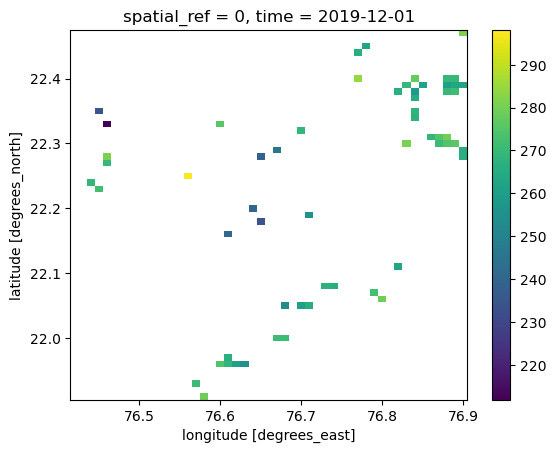

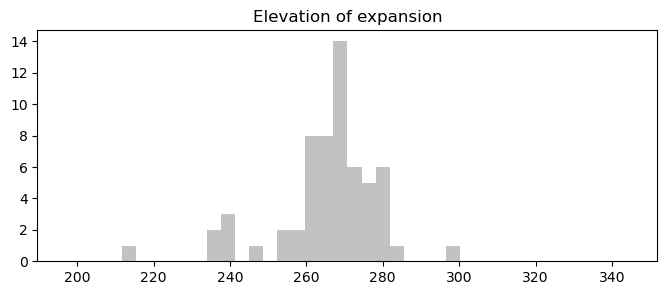

In [20]:
dem_expand_vals , ax_expand = map_data_array_values(dem_expand.isel(time=15),
                                                    fig_kwargs={'figsize':(8,3)},
                                                   hist_kwargs=hist_kwargs,
                                                   )

ax_expand[1].set_title('Elevation of expansion')

Text(0.5, 1.0, 'Elevation of shrinkage')

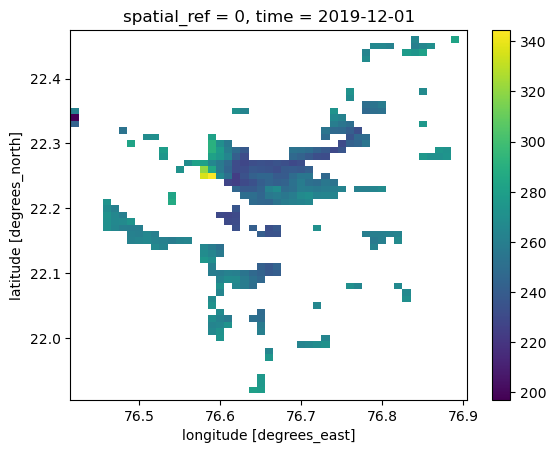

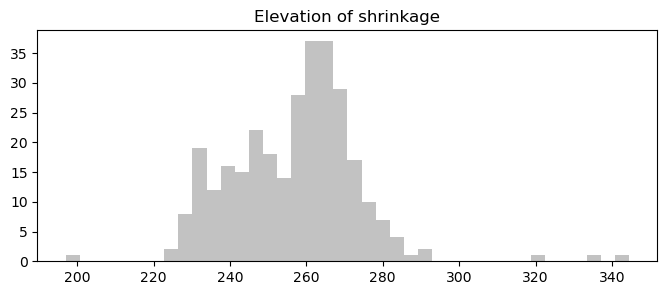

In [21]:
dem_decline_vals , ax_decline = map_data_array_values(dem_decline.isel(time=15),
                                                      fig_kwargs={'figsize':(8,3)},
                                                      hist_kwargs=hist_kwargs,
                                                     )

ax_decline[1].set_title('Elevation of shrinkage')

Text(0.5, 1.0, 'Elevation')

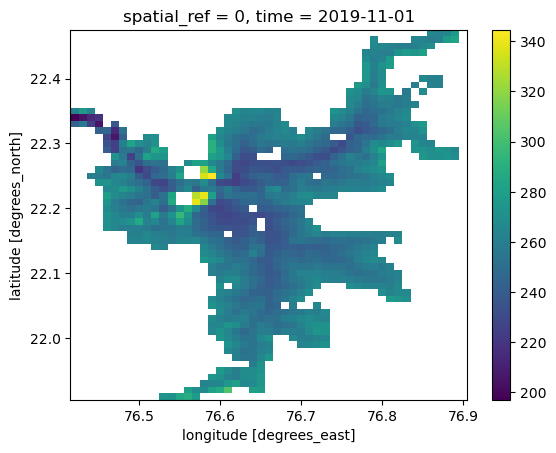

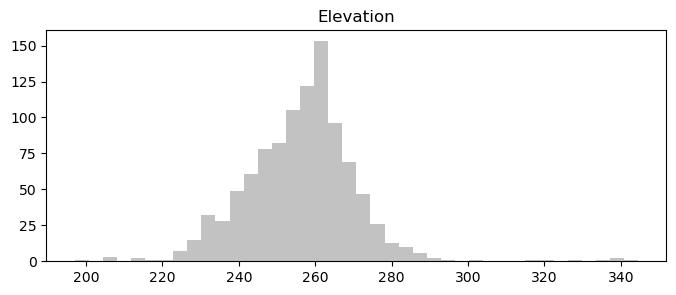

In [22]:
dem_subset = dem_DA.where(fw_DA_binary==1)
dem_test0_vals , ax_test = map_data_array_values(dem_subset.isel(time=15),
                                                    fig_kwargs={'figsize':(8,3)},
                                                   hist_kwargs=hist_kwargs,
                                                   )

ax_test[1].set_title('Elevation')

Text(0.5, 1.0, 'Elevation')

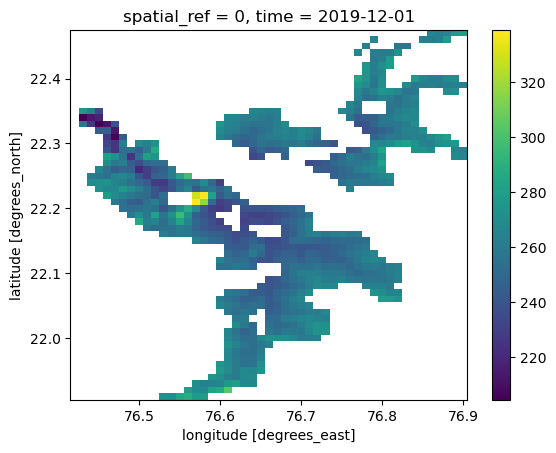

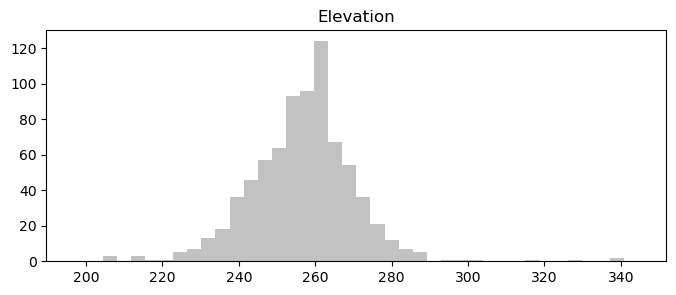

In [23]:
dem_test1_vals , ax_test = map_data_array_values(dem_subset.isel(time=16),
                                                    fig_kwargs={'figsize':(8,3)},
                                                   hist_kwargs=hist_kwargs,
                                                   )

ax_test[1].set_title('Elevation')

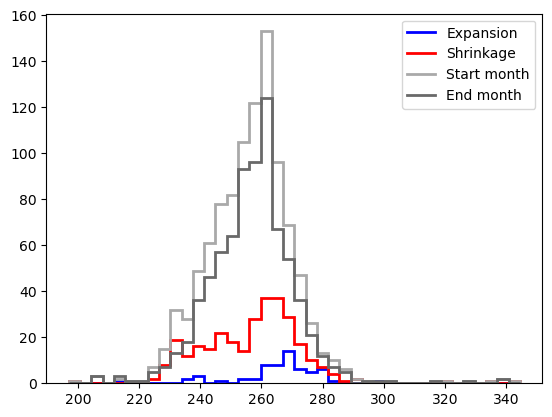

In [24]:
#3. Get the modal elevation
plt.figure()
plt.stairs(dem_expand_vals[0],dem_expand_vals[1], color='blue',linewidth=2)
plt.stairs(dem_decline_vals[0],dem_decline_vals[1], color='red',linewidth=2)
plt.stairs(dem_test0_vals[0],dem_test0_vals[1], color='darkgrey',linewidth=2)
plt.stairs(dem_test1_vals[0],dem_test1_vals[1], color='dimgrey',linewidth=2)
plt.legend(['Expansion','Shrinkage','Start month','End month'])

## Fit a few scipy distributions to the data 
Try:
- [loggamma](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.loggamma.html#scipy.stats.loggamma)
- [normal](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html#scipy.stats.norm)

In [25]:
from scipy.stats import norm, loggamma, mode

In [26]:
def extract_just_values_from_dem_tuple(dem_tuple):
    dem_just_vals = dem_tuple[2][~np.isnan(dem_tuple[2])]
    return dem_just_vals

In [27]:
def fit_distribution_from_dem_tuple(dem_tuple,function_name):
    dem_just_vals = extract_just_values_from_dem_tuple(dem_tuple)
    fit_params = function_name.fit(dem_just_vals)
    return fit_params

In [28]:
def plot_distribution_from_dem_tuple(dem_tuple,function_name, plt_kwargs={}, ax = None, hist=False , hist_kwargs = {}):
    if ax is None:
        ax = plt.gca()
    fit_params = fit_distribution_from_dem_tuple(dem_tuple,function_name)
    x = dem_tuple[1]
    ax.plot(x,function_name.pdf(x,*fit_params),**plt_kwargs)
    if hist:
        just_vals = extract_just_values_from_dem_tuple(dem_tuple)
        plot_hist_from_nparray(just_vals, hist_kwargs ,ax = ax)
    return fit_params

start month: (256.334615848126, 14.59243682154075)
decline values: (256.73865896080446, 16.67898822650821)
end month: (256.89233608814675, 13.852645550126878)


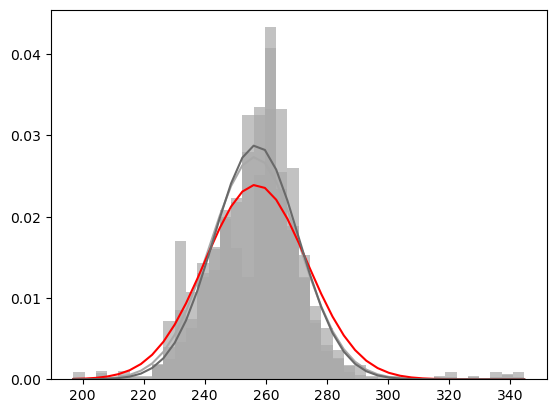

In [29]:
hist_kwargs['density']=True
params1 = plot_distribution_from_dem_tuple(dem_test0_vals,norm,hist=True,hist_kwargs=hist_kwargs,plt_kwargs={'color':'darkgrey'})
params2 = plot_distribution_from_dem_tuple(dem_decline_vals,norm,hist=True,hist_kwargs=hist_kwargs,plt_kwargs={'color':'red'})
params3 = plot_distribution_from_dem_tuple(dem_test1_vals,norm,hist=True,hist_kwargs=hist_kwargs,plt_kwargs={'color':'dimgrey'})

print('start month:',params1)
print('decline values:',params2)
print('end month:',params3)

## Calculating Volume (finally)

In [30]:
# 1. Grab surface area at start time
# 2. Calculate change in elevation (using questionable methodology)
# 3. Calculate volume change

In [31]:
def calculate_rough_area(input_DA):
    pixel_count = input_DA.sum()
    area_deg2 = 0.01 *0.01 * pixel_count.values
    return area_deg2

In [32]:
# Grab surface area at start time
# 1. reproject
# 2. Get area
calculate_rough_area(fw_DA_binary.isel(time=15))

0.1018

In [33]:
0.1018 * (256.73865896080446 - 256.334615848126)

0.041131588870664884

## Testing volume_pipeline functions

In [3]:
from codebase import volume_pipeline

In [4]:
# Step 1 wrapper function works
dem_DA , fw_DA = volume_pipeline.create_aligned_DEM_CYGNSS_subsets('Indirasagar',res_shp)

In [5]:
# Step 2 function works
fw_diff_DA = volume_pipeline.difference_over_time(fw_DA)

In [6]:
# Step 3 single timestep and vectorized work.
change_cond_DA = volume_pipeline.decide_expansion_or_shrinkage_vectorize(fw_diff_DA)

# Testing out vectorization of Step 3 (label as expand/shrink for each timestep)
test_vectorized = xr.apply_ufunc(volume_pipeline.decide_expansion_or_shrinkage_timestep,
                                 fw_diff_DA,input_core_dims=[['lat','lon']],vectorize=True)

In [7]:
# Step 4 wrapper function works
from scipy.stats import norm
change_cond_time0 = change_cond_DA.isel(time=0)
fw_diff_time0 = fw_diff_DA.isel(time=0)
fw_time0 = fw_DA.isel(time=0)
start_params = volume_pipeline.fit_DEM_distribution_from_conditional_area(dem_DA, fw_time0, 1, norm)
change_params = volume_pipeline.fit_DEM_distribution_from_conditional_area(dem_DA, fw_diff_time0, change_cond_time0, norm)
print('params of start timestep:',start_params)
print('params of change in area:',change_params)

params of start timestep: (257.2609612698588, 17.42481840990914)
params of change in area: (259.5148348731124, 16.753825029340693)


In [44]:
## Could not vectorize the Step 4 function(s). Skipped vectorization and made for loop functions :(

# from xarray import DataArray
# def grab_DEM_of_conditional_area(
#     dem_DA: DataArray, cond_DA: DataArray, cond: int = 1
# ) -> DataArray:
#     print(type(dem_DA), type(cond_DA) , cond)
#     print(dem_DA.shape)
#     dem_cond_area = dem_DA.where(cond_DA == cond)
#     return dem_cond_area


# xr.apply_ufunc(grab_DEM_of_conditional_area,
#                fw_DA,input_core_dims=[['lat','lon']],kwargs={'dem_DA':dem_DA},
#               vectorize=True, output_core_dims=['time'])

# xr.apply_ufunc(volume_pipeline.fit_DEM_distribution_from_conditional_area,
#                dem_DA,fw_DA[:-1,:,:],change_cond_DA,norm,
#               input_core_dims=[['lat','lon'],['lat','lon'],[],[]],
#               vectorize=True, join='right')

In [8]:
test_height = volume_pipeline.calculate_height_time_series_from_start_and_change_in_DEM(dem_DA,fw_DA,fw_diff_DA,change_cond_DA)

In [16]:
from numpy import testing


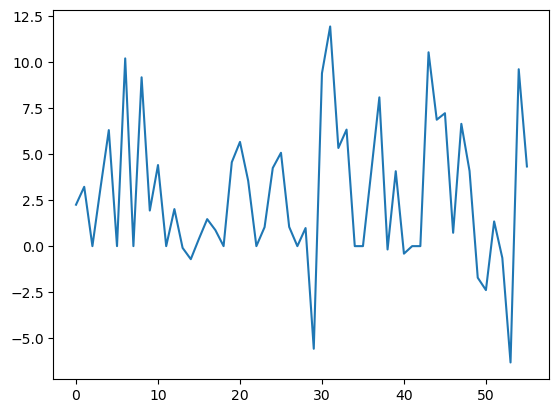

In [9]:
screened_test_height = test_height *np.abs(change_cond_DA.values)
plt.plot(screened_test_height)